In [2]:
!pip install segyio
import segyio
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

     |████████████████████████████████| 83 kB 1.6 MB/s eta 0:00:011


In [3]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
#         print(x.size())
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
#         print(x.size())
        return x

In [4]:
# unit test
def test_contracting_block(test_samples = 1, test_channels=1, test_size=254):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    # Make sure that the first convolution has the right shape
    print(test_out_conv1.shape)
#     print(test_block.shape)

In [5]:
test_contracting_block(128)
# 1, 512, 60, 60

torch.Size([128, 2, 254, 254])


In [6]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)        
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [7]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    #x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    print(x.shape)
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
#     orginal_x = crop(skip_con_x, x.shape)
#     x = torch.cat([x, orginal_x], axis=1)
#     x = test_block.conv2(x)
#     # Make sure that the second convolution produces the right shape
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
#     x = test_block.conv3(x)
#     # Make sure that the final convolution produces the right shape
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
#     x = test_block.activation(x)

test_expanding_block()
# print("Success!")

torch.Size([1, 1024, 64, 64])


In [8]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [9]:
# UNIT TEST
# assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
# print("Success!")

# print(FeatureMapBlock(1, 64)(torch.randn(1, 1, 512, 512)).shape)

In [10]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels.                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)        
        x2 = self.contract2(x1)        
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)          
        return xn

In [11]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


In [12]:
# First load datasets

filename_pp = "../input/equinor-data/issap20_Pp.sgy"
filename_ai = "../input/equinor-data/issap20_AI.sgy"
filename_fault = "../input/equinor-data/issap20_Fault.sgy"

In [13]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

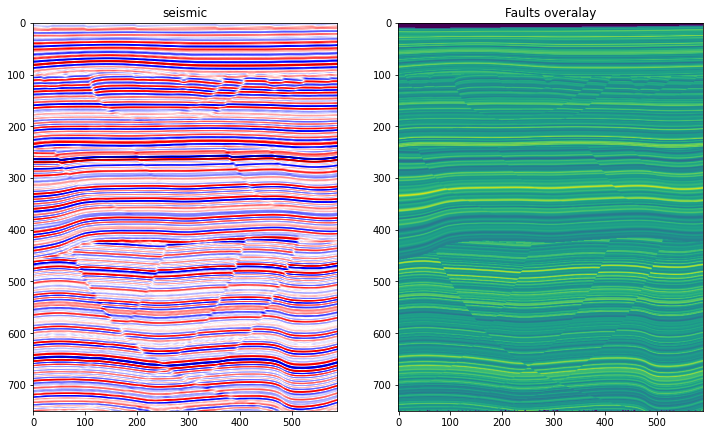

In [14]:
# plot inline
ILINE=10
plt.figure(figsize=(12, 10))
title = ['seismic', 'Faults overalay']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic, ai]):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap=cmaps[i])
#     plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()



In [15]:
print(fault[ILINE,:, :])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

# Function to pad 
import torch.nn.functional as F

def pad_to(image, new_shape):
    '''
    Function for padding an image tensor. 
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

In [17]:
# Some manipulation to get the data into right shape to be input for the UNET model.

'''
Earlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)
The Pytorch implementation requires: (m, n, h, w) shape where,
m = no. of samples (in this case, no. of inlines)
n = number of channel ( 1 for greyscale or single channel)
h, w = 512
By concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.
After that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)
Finally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)
'''

'\nEarlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)\nThe Pytorch implementation requires: (m, n, h, w) shape where,\nm = no. of samples (in this case, no. of inlines)\nn = number of channel ( 1 for greyscale or single channel)\nh, w = 512\nBy concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.\nAfter that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)\nFinally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)\n'

In [18]:
new_shape = (256, 256)
image_list = []
fault_list = []
for i in range(101):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))
    
    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

In [19]:
image_list[0].shape

torch.Size([1, 256, 256])

In [20]:
# Loading data into Pytorch Dataset Utitlity
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [21]:
volumes.shape, labels.shape

(torch.Size([101, 1, 256, 256]), torch.Size([101, 1, 256, 256]))

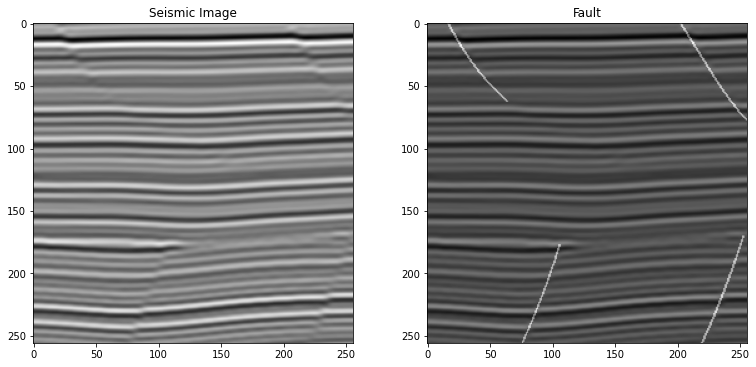

In [22]:
# One last sanity check
fig = plt.figure(figsize=(20,20))
    
ax = fig.add_subplot(331)    
plt.imshow(volumes[0].T, cmap="gray");
ax.set_title("Seismic Image")
    
ax = fig.add_subplot(332)
ax.imshow(volumes[0].T, cmap = 'gray')
ax.imshow(labels[0].T, cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
ax.set_title("Fault")
plt.show();

In [23]:
# Special function to display images side by side after training

def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor
    
    image_unflat = image.detach().cpu()
    fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()
    
    
    fig = plt.figure(figsize=(12,15))
    
    ax = fig.add_subplot(331)    
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")
    
    ax = fig.add_subplot(332)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(fault_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(pred_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()

In [24]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [25]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 25  
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 256
target_shape = 256
device = 'cuda'

In [26]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    
    train_losses = []

    for epoch in range(n_epochs):
                
        for real, labels in tqdm(dataloader):
            
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)            
                      

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            #print(pred.shape)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()
            

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                #show_tensor_images(
                    #crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    #size=(input_dim, target_shape, target_shape)
                #)
                #show_tensor_images(real.T, size=(input_dim, target_shape, target_shape))                
                #show_tensor_images(labels.T, size=(label_dim, target_shape, target_shape))
                #show_tensor_images(torch.sigmoid(pred).T, size=(label_dim, target_shape, target_shape))
                show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))
            cur_step += 1
        
        train_losses.append(unet_loss)
               
        
    return unet, pred, train_losses

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.7138838768005371


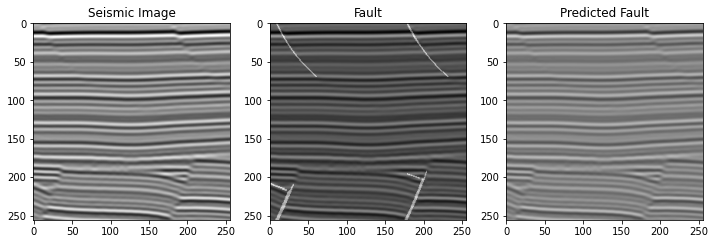

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Step 500: U-Net loss: 0.06147896498441696


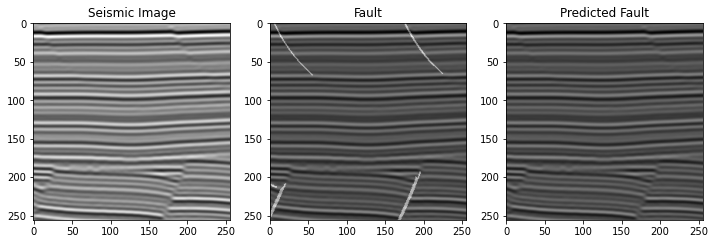

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Step 1000: U-Net loss: 0.06267529726028442


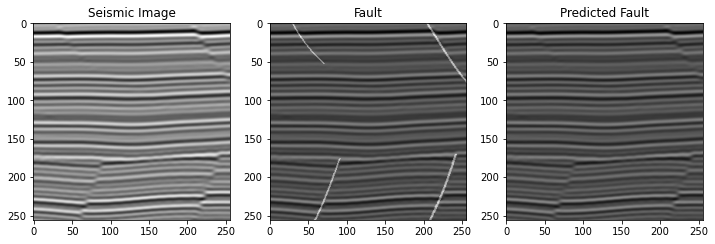

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 14: Step 1500: U-Net loss: 0.023355970159173012


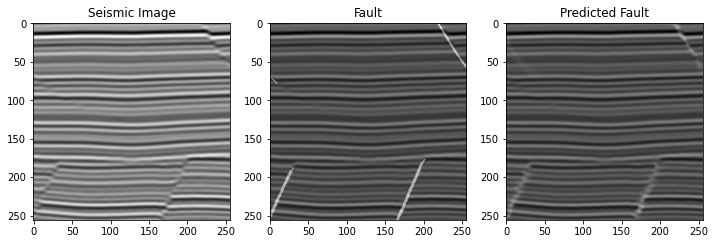

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 19: Step 2000: U-Net loss: 0.012157188728451729


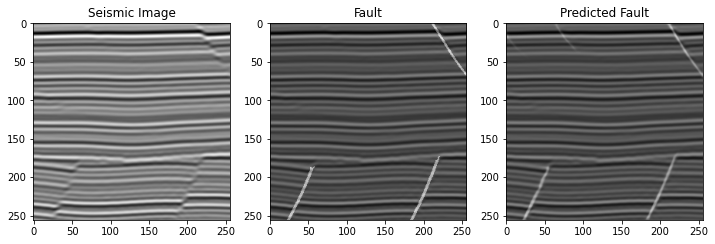

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 24: Step 2500: U-Net loss: 0.014057541266083717


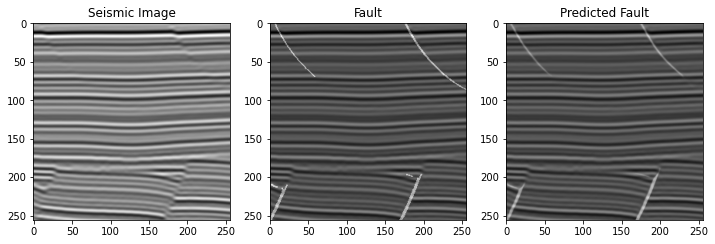

In [27]:
model, pred, loss = train()

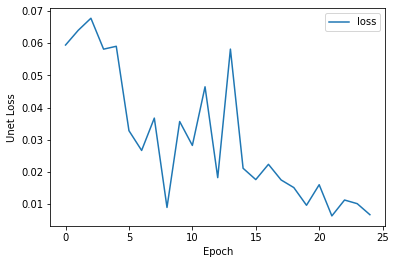

In [28]:
plt.plot(loss, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Unet Loss')
plt.legend()
plt.show()

In [29]:
# # Save weights
# model_path = "D:/Machine_Learning/Xeek.ai/Fault_detection/model_weights/unet1.pth"
# torch.save(model.cpu().state_dict(), (model_path))
# # model.eval()

In [30]:
# import pickle



# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))
 
    
    
    
    
# some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [31]:
# print(model)

In [32]:
# print(model.state_dict())

In [33]:
# checkpoint = {'model': train(),
#               'state_dict': model.state_dict(),
#               'optimizer' : model.state_dict()}

# torch.save(model.state_dict(), 'checkpoint.pth')


# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model(real)
# print(result)

In [34]:
# load1 = torch.load('./checkpoint.pth')

In [35]:

# print(load1)



In [36]:
# print(load1)

In [37]:
    
#     image_unflat = image.detach().cpu()
#     fault_unflat = fault.detach().cpu()

    
# fig = plt.figure(figsize=(12,15))
    

    
# ax = fig.add_subplot(111)
# #     ax.imshow(image_unflat.squeeze(), cmap = 'gray')
# ax.imshow(result)
# ax.set_title("Predicted Fault")
    
# plt.show()

In [38]:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model(pred)
# print(result)

In [39]:
# load1.train()
# output = load1(volumes[1])

In [40]:
PATH = './checkpoint.pth'

torch.save(model.state_dict(), PATH)


# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()


In [41]:
# model1 = UNet()
model.load_state_dict(torch.load(PATH))
model.eval()

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (contract1): ContractingBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract2): ContractingBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract3): ContractingBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (maxpool):

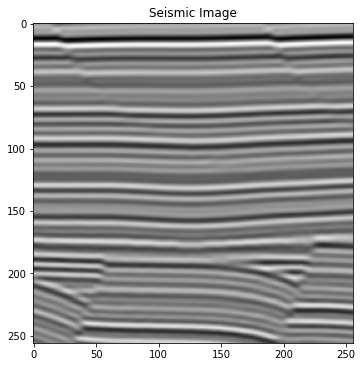

In [42]:
fig = plt.figure(figsize=(20,20))
    
ax = fig.add_subplot(331)    
plt.imshow(volumes[100].T, cmap="gray");
ax.set_title("Seismic Image")
    
plt.show();

In [43]:
# prediction1 = model()

In [44]:
# save_path = './mlp.pth'
# mlp = MLP()
# mlp.load_state_dict(torch.load(save_path))
# mlp.eval()
    
#     # Generate prediction
# prediction = mlp(image)

In [45]:
# print(pred.shape)

In [46]:
# print(volumes.shape)

In [47]:
model = model.to(device)
outputs = model(volumes[1:2].to(device))

In [48]:
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             
#     torch.cuda.empty_cache()
#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()

In [49]:
# model = model.to(device)
# outputs = model(volumes.to(device))

In [50]:
print(outputs)

tensor([[[[-19.5226, -24.0897, -24.2212,  ...,  -7.8694,  -6.7077,  -4.6569],
          [-27.2238, -31.0894, -30.1454,  ...,  -9.9514,  -8.6390,  -6.5949],
          [-30.0534, -32.7923, -31.5712,  ..., -10.9746,  -9.8575,  -7.8780],
          ...,
          [ -5.2458,  -6.0579,  -5.7606,  ..., -11.8692, -11.6273, -11.0143],
          [ -4.2856,  -5.1928,  -4.9211,  ..., -12.7432, -12.2589, -11.0907],
          [ -2.4896,  -3.3745,  -3.8183,  ..., -11.3722,  -9.9243,  -7.9011]]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [51]:
outputs.shape

torch.Size([1, 1, 256, 256])

In [52]:
def show_tensor_images2(image, pred, num_images=2, size=(1, 25, 25)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor
    
    image_unflat = image.detach().cpu()
#     fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()
    
    
    fig = plt.figure(figsize=(20,20))
    
    ax = fig.add_subplot(221)    
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")
       
    ax = fig.add_subplot(222)

    ax.imshow(pred_unflat.squeeze(), cmap = 'binary', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()

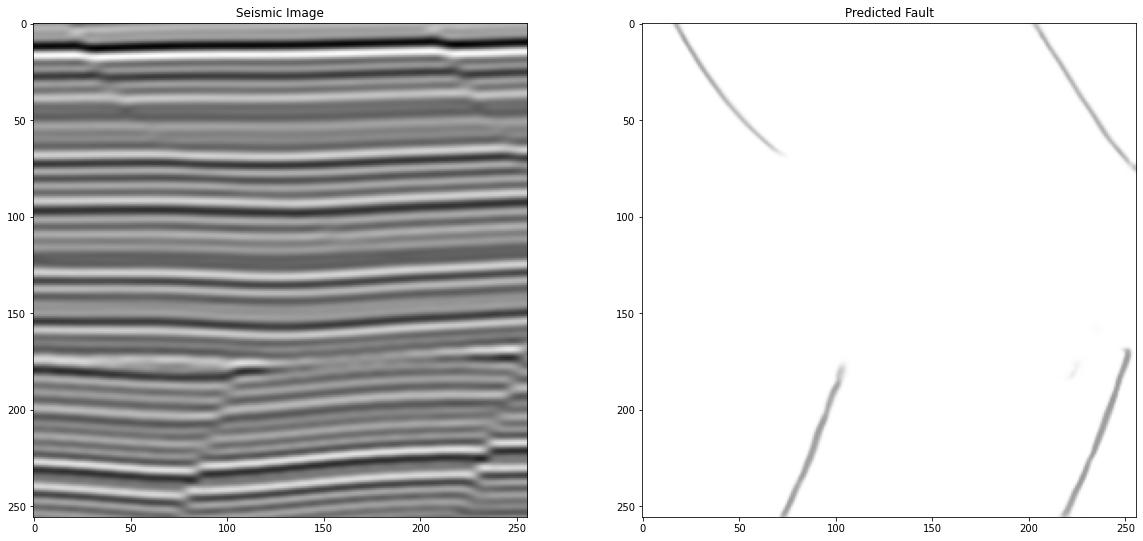

In [53]:
abc = volumes[1:2];

show_tensor_images2(abc.T,  torch.sigmoid(outputs).T, size=(input_dim, target_shape, target_shape))

In [54]:
filename_dutch = "../input/datawaldeman/data.segy"

In [55]:
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename) as segyfile:
        return segyio.tools.cube(segyfile)

dutch = segy2numpy(filename_dutch)
f"Number of inlines: {dutch.shape[0]}, crosslines: {dutch.shape[1]}, samples: {dutch.shape[2]}"



'Number of inlines: 651, crosslines: 951, samples: 462'

In [56]:
new_shape = (256, 256)
volumes1 = []
fault_list = []
for i in range(651):
    images = torch.from_numpy(dutch[i])
    
    cropped_image1 = images[400:656, 200:456] 

    volumes1.append(cropped_image1.unsqueeze(0))

In [57]:
# new_shape = (256, 256)
# image_list1 = []

# for i in range(650):
#     images1 = torch.from_numpy(dutch[i])
#     image_list1.append(crop_input(images1, new_shape ).unsqueeze(0))
    
# volumes1 = torch.stack(image_list1)
# volumes1.shape

In [59]:
volumes2 = torch.stack(volumes1)

In [64]:
outputs1 = model(volumes2[200:201].to(device))

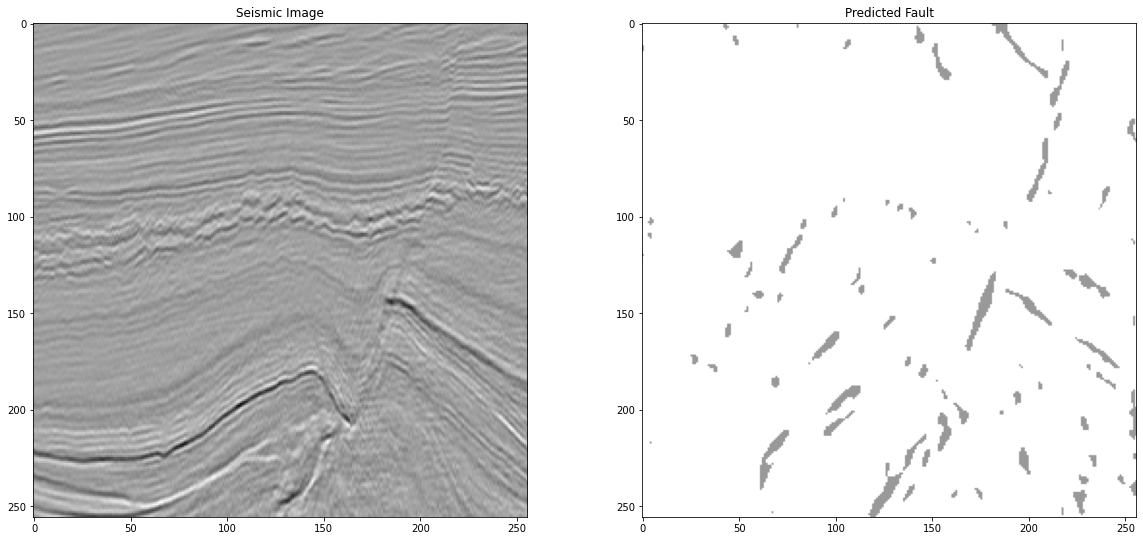

In [65]:
abc = volumes2[200:201];

show_tensor_images2(abc.T,  torch.sigmoid(outputs1).T, size=(input_dim, target_shape, target_shape))